# Testing and illustrating the Toropti
The optimal_traffic_scheduler (**OTS**) class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from optimal_traffic_scheduler import optimal_traffic_scheduler
import pdb
%matplotlib notebook

We create a simple scenario to illustrate and investigate the mechanics of the **OTS** class. For this purpose we start by creating a setup_dict for our optimizer that carries the same (and some additional) information as the server nodes in **NS-F**:

In [2]:
setup_dict = {}
setup_dict['v_max'] = 20  # packets / s
setup_dict['s_max'] = 30  # packets
setup_dict['dt'] = 1  # s
setup_dict['N_steps'] = 20
setup_dict['v_delta_penalty'] = 2

- **v_max**: is the maximum number of packets that can be processed per second. Processing means the sum of all incoming and outgoing packets. As these incoming and outgoing packets share the same band they are collectively limited.
- **s_max**: is the maximum number of packets in the server. The NS-F server nodes rejects packets (they are lost) if this value is to be exceeded otherwise.
- **dt**: Timestep of the **OTS** object. Note that this should be at least an order of magnitude greater than the **NS-F** server timestep.
- **N_steps**: Prediction horizon for the MPC problem.
- **v_delta_penalty**: This term penalizes high changes (with regard to the L2-Norm) in the controlled variables and is important to ensure stability of the distributed system.

We can now create the object:

In [3]:
ots = optimal_traffic_scheduler(setup_dict)

We look into **OTS** with a concrete example. Lets assume that we have two inputs and three outputs for the node and that a total of five circuits are beeing processed. This can simply be expressed as follow:

In [4]:
circuits_in = [[0, 1, 2], [3, 4]]
circuits_out = [[1, 3], [0], [2, 4]]

Normally, this information would be automatically retrieved from the network structure, along with additional values. For this example we do some manual calculations to configure the node:

In [5]:
n_in = len(circuits_in)
n_out = len(circuits_out)
n_circuit_in = [len(c_i) for c_i in circuits_in]
n_circuit_out = [len(c_i) for c_i in circuits_out]
print('The {0} incoming connections carry {1} circuits \
and the {2} outgoing connections have {3} circuits.'.format(n_in,n_circuit_in,n_out,n_circuit_out))
print('Clearly, sum(n_circuits_in) = {0}, is the same as sum(n_circuits_out) = {1}'.format(np.sum(n_circuit_in),np.sum(n_circuit_out)))

The 2 incoming connections carry [3, 2] circuits and the 3 outgoing connections have [2, 1, 2] circuits.
Clearly, sum(n_circuits_in) = 5, is the same as sum(n_circuits_out) = 5


We can now sestup the **OTS** object:

In [6]:
ots.setup(n_in, n_out, n_circuit_in, n_circuit_out)

Two very important matrices are calculated with staticmethods from the **OTS** object:

In [7]:
Pb = ots.Pb_fun(circuits_in, circuits_out)
Pc = ots.Pc_fun(circuits_in, circuits_out)

Pb is an assignment matrix that determines, which element of each input is assigned to which output buffer. What this means becomes clear when we display it for the example circuit constellation:

In [8]:
Pb

array([[0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1.]])

Each row corresponds to one output and each column to one input circuit. We see that the input circuits at position 1 and 3 are directed to output 0, for example.

Pc, on the other hand, is an assignment matrix to determine which input circuit is directed to which output circuit:

In [9]:
Pc

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

This is an quadratic matrix as the number of circuits cant change within a node. Basically, this matrix just changes the order of the circuits.

We know create a scenario in which the optimization is triggered with some dummy values. We set the following for the initial condition:

In [10]:
s_buffer_0 = np.zeros((n_out, 1))
s_circuit_0 = np.zeros((np.sum(n_circuit_in), 1))

Where ```s_buffer``` is a n_out x 1 vector with one component for each output queue of the server and ```s_circuit``` is a n_circuit x 1 vector with one component for each circuit. These values represent the number of packets per buffer and circuit.

We also introduce some trajectories that are obtained in adjacent nodes and communicated with the current node. For our example we again choose some dummy values:

In [11]:
v_in_req = [np.array([[12, 4]]).T]*ots.N_steps

cv_in = [[np.array([[0.5, 0.25, 0.25]]).T, np.array([[0.5, 0.5]]).T]]*ots.N_steps

v_out_max = [np.array([[6, 6, 6]]).T]*ots.N_steps

bandwidth_load_target = [np.array([[0, 0, 0]]).T]*ots.N_steps
memory_load_target = [np.array([[0, 0, 0]]).T]*ots.N_steps

bandwidth_load_source = [np.array([[0, 0]]).T]*ots.N_steps
memory_load_source = [np.array([[0, 0]]).T]*ots.N_steps

Note, first of all, the format of all these trajectories. Each of them is represented by a list with N items, where each list item is a vector that represents the value of that trajectory at a distinct timestep for a total of N timesteps. 
Now to the individual explanations:
- **v_in_req**: Is the requested incoming packet stream of the connected sending nodes. Ideally our node excepts all of this data, however, it can choose to reject some of it.
- **cv_in**: Is the composition of the incoming packet streams. Each list item is again a list. Each of these elements corresponds to one of the incoming streams and is itself a composition vector. Note the similarity to the ```circuits_in``` definition from above.
- **v_out_max**: The maximum allowed packet stream of the outgoing connections. 
- **bandwidth_load_target / memory_load_target**: Load information for the target servers
- **bandwidth_load_source / memory_load_source**: Load information for the source servers

## Test 01: Investigate dynamics
For our first test we do not solve the optimal control problem but instead manually set the control inputs and investigate the system dynamics. 

In [12]:
v_in_max = [np.array([[12, 4]]).T]*ots.N_steps
v_out = [np.array([[5, 6, 5]]).T]*ots.N_steps

We can control the upper limit for the incoming packet streams, where the resulting incoming packet stream is simply 
```python
   v_in = fmin(v_in_max, v_in_req)
```
where ```fmin``` is a casadi method. Furthermore, we are able to control the sending rate individually for each output_buffer. 

The dynamics of the system are quite simple. We have an auxiliary variable $v_{c,in}$ that derives from $v_{in}$ and $c_{v,in}$ and denotes the incoming packet streams for each circuit. With this value and the previous buffer memory ($s^{k}_B$) and circuit memory ($s^{k}_C$) we calculate intermediate values for the next buffer and circuit memory. We need the matrices $P_B$ and $P_C$ that were introduced above:
\begin{gather}
\tilde{s}^{k+1}_B= s^{k}_B +\Delta t \cdot P_B  v_{c,in}\\
\tilde{s}^{k+1}_C = s^{k}_C +\Delta t \cdot P_C  v_{c,in}\\
\end{gather}
With the intermediate circuit and buffer memory we calculate the composition of the outgoing packet stream, simply by dividing the respective elements of $\tilde{s}^{k+1}_C$ and $\tilde{s}^{k+1}_B$. 
Now, we can use to calculate the outgoing circuit streams $v_{c,out}$ by using $v_{out}$ and $c_{v,out}$. 
This allows to write:
\begin{gather}
s^{k+1}_B= \tilde{s}^{k+1} -\Delta t \cdot v_{out}\\
s^{k+1}_c = \tilde{s}^{k+1}_C -\Delta t \cdot v_{c,out}\\
\end{gather}


Let's check these dynamics with the chosen input trajectories from above. Note that ```v_out``` was chosen, such that all incoming packets are forwarded immediatly. 

In [13]:
model_fun = ots.mpc_problem['model'] # Retrieve the model function from the ots object.

# Initiate lists for the solution, starting with the intial condition.
s_buffer = [s_buffer_0]
s_circuit = [s_circuit_0]
cv_out = []
for k in range(ots.N_steps):
    model_out = model_fun(s_buffer[k], s_circuit[k], v_in_req[k], v_in_max[k], *cv_in[k], v_out[k], Pb, Pc)
    model_out = [model_out_i.full() for model_out_i in model_out]
    # model_out is a list, where the following items correspond to the following variables:
    s_buffer.append(model_out[0])
    s_circuit.append(model_out[1])
    cv_out.append(model_out[2:])
    
# Concatenate the solution:
s_buffer = np.concatenate(s_buffer, axis=1).T
s_circuit = np.concatenate(s_circuit, axis=1).T

Both, ```s_buffer``` and ```s_circuit``` are zero for all elements and all timesteps, which is shown below for s_circuit:

In [14]:
s_circuit

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

The interesting value is therefore the composition, which is shown below:

In [15]:
for k in range(ots.N_steps):
    print([c_i.flatten().tolist() for c_i in cv_out[k]])

[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]


These are exactly the values that we expected, e.g:


\begin{gather}
v_{in,0}\cdot c_{in,0,1} = 12\cdot0.25 = 3\\
v_{in,1}\cdot c_{in,1,0} = 4\cdot0.25 = 2
\end{gather}
Are added to output buffer 0 and $v_{out,1}$ is set to $3+2 = 5$. Such that the composition is:
\begin{gather}
c_{out,0,0} = 3 / 5 = 0.6\\
c_{out,0,0} = 2 / 5 = 0.4
\end{gather}

Know we quickly investigate how it looks like when the buffer is increasing in size, simply by setting:

In [16]:
v_out = [np.array([[4.5, 5, 3]]).T]*ots.N_steps

and rerunning:

In [17]:
# Initiate lists for the solution, starting with the intial condition.
s_buffer = [s_buffer_0]
s_circuit = [s_circuit_0]
cv_out = []
for k in range(ots.N_steps):
    model_out = model_fun(s_buffer[k], s_circuit[k], v_in_req[k], v_in_max[k], *cv_in[k], v_out[k], Pb, Pc)
    model_out = [model_out_i.full() for model_out_i in model_out]
    # model_out is a list, where the following items correspond to the following variables:
    s_buffer.append(model_out[0])
    s_circuit.append(model_out[1])
    cv_out.append(model_out[2:])
    
# Concatenate the solution:
s_buffer = np.concatenate(s_buffer, axis=1).T
s_circuit = np.concatenate(s_circuit, axis=1).T

Clearly the buffer and circuit memory is now growing:

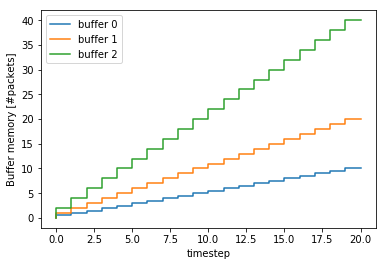

In [18]:
line = plt.step(np.arange(s_buffer.shape[0]),s_buffer)
plt.legend(line, ['buffer {}'.format(i) for i in range(n_out)])
plt.ylabel('Buffer memory [#packets]')
plt.xlabel('timestep')
plt.show()

But the composition of the outgoing packet streams is unchanged, as expected.

In [19]:
for k in range(ots.N_steps):
    print([np.round(c_i,1).flatten().tolist() for c_i in cv_out[k]])

[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]
[[0.6, 0.4], [1.0], [0.6, 0.4]]


## Investigate MPC solver:

Knowing that the dynamics are plausible we can now test the MPC solver. But first lets state the OCP:
- objective (for one stage):
\begin{equation}
\underset{v_{in,max},v_{out}}{\text{minimize}}\quad 
\sum_i^{n_{out}}(1-L_{BW,i}^{T})(1-L_{M,i}^{T})\left(-\frac{v_{out}}{v_{max}}+\frac{s_B}{s_{max}}\right)
+\sum_i^{n_{in}}L_{BW,i}^{S}L_{M,i}^{S}\left(-\frac{v_{in,max}}{v_{max}}\right)
+a(||v_{out}^k-v_{out}^{k-1}||_2^2
+||v_{in,max}^k-v_{in,max}^{k-1}||_2^2)
\end{equation}


- constraints:
\begin{gather}
\sum_i^{n_{in}} v_{in,i} + \sum_i^{n_{out}} v_{out,i} \leq v_{max}\\
s_B \geq 0\\
0 \leq v_{out} \leq v_{out,max}\\
v_{in,max}\leq v_{max}
\end{gather}

we can now call the solver:

In [20]:
ots.solve(s_buffer_0, s_circuit_0, v_in_req, cv_in, v_out_max, Pb, Pc, bandwidth_load_target, memory_load_target, bandwidth_load_source, memory_load_source)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2150
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

The results of the optimization problem are solved in ```ots.predict```:

In [30]:
sol=ots.predict[-1]

v_in_req = np.concatenate(sol['v_in_req'],axis=1).T
v_in = np.concatenate(sol['v_in'],axis=1).T
s_b = np.concatenate(sol['s_buffer'],axis=1).T
v_out = np.concatenate(sol['v_out'],axis=1).T

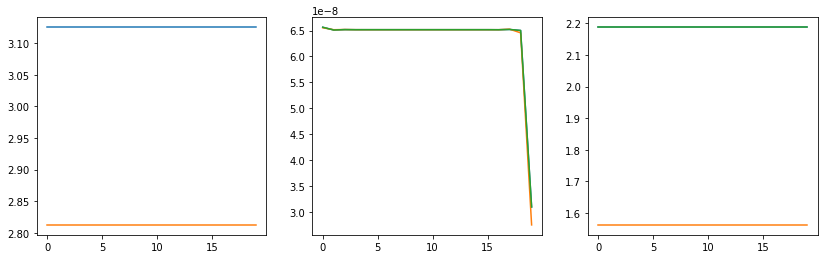

In [33]:
fig, ax = plt.subplots(1,3, figsize=[14,4])
ax[0].plot(v_in)
ax[1].plot(s_b)
ax[2].plot(v_out)
plt.show()